In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import shutil
from PIL import Image
from imgaug import augmenters as iaa
import numpy as np
import pandas as pd
import time
import dask.bag as db
import dask.diagnostics as dd
import random
from termcolor import colored
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2M, EfficientNetV2B0, EfficientNetV2B2, Xception, ResNet50
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, F1Score

In [2]:
CWD = os.getcwd()
CWD

'/Users/irfani/Library/CloudStorage/OneDrive-TelkomUniversity/irfani/Telkom University/7_Semester 7/TA/Penelitian'

# Preprocessing

####function

In [3]:
def load_images_from_folder(folder_path):
    images = []
    image_names = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path) and filename.endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(img_path).convert('L')
            images.append(np.array(img))
            image_names.append(filename)
    return np.array(images), image_names

In [4]:
def library_augment_images(images, num_images_addition=2):
    seq = iaa.Sequential([
        iaa.Affine(
            rotate=(-25, 25),  # rotation
            # shear=(-15, 15),   # shearing
            # translate_percent={"x": (-15, 15), "y": (-15, 15)}  # translation
        )
    ])

    augmented_images = []
    for img in images:
        augmented_images.append(img)
        augmented_images.extend(seq(images=[img] * (num_images_addition - 1)))

    return np.array(augmented_images)

In [5]:
def save_images(list_images, list_image_names, move_to, list_folder_path, prefix="aug"):
    move_to = "dataset/" + move_to
    move_path = os.path.join(CWD, move_to)

    if os.path.exists(move_path):
        shutil.rmtree(move_path)
        print(f"Removed existing directory: {move_path}")
    os.makedirs(move_path)

    for path, images, image_names in zip(list_folder_path, list_images, list_image_names):
        print(len(images))
        if os.path.exists(path):
            shutil.rmtree(path)
            print(f"Removed existing directory: {path}")
        os.makedirs(path)

        for i, img in enumerate(images):
                    if i < len(image_names):
                        base_name, ext = os.path.splitext(image_names[i])
                        augmented_image_name = f"{base_name}{ext}"
                    else:
                        augmented_image_name = f"{prefix}_{i}.png"

                    augmented_image_pil = Image.fromarray(img)
                    augmented_image_path = os.path.join(path, augmented_image_name)
                    augmented_image_pil.save(augmented_image_path)

In [6]:
def add_noise(image, mean=0, std=10):
    noise = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy_image = image.astype(np.float32) + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return noisy_image

In [7]:
def gamma_correction(images, gamma):
    images = images/255.0
    corrected_images = np.power(images, gamma)
    corrected_images = np.clip(corrected_images * 255.0, 0, 255).astype(np.uint8)

    return corrected_images

In [8]:
def preprocess_input_grayscale_to_rgb(img):
    return np.stack((img,)*3, axis=-1)

#### implementation

In [9]:
RAW_FOLDER=[
    CWD+'/dataset/raw/glioma_tumor',
    CWD+'/dataset/raw/meningioma_tumor',
    CWD+'/dataset/raw/pituitary_tumor',
    CWD+'/dataset/raw/normal'
]

GLIOMA_PATH = RAW_FOLDER[0]
MENINGIOMA_PATH = RAW_FOLDER[1]
PITUITARY_PATH = RAW_FOLDER[2]
NORMAL_PATH = RAW_FOLDER[3]


In [10]:
glioma, glioma_names = load_images_from_folder(GLIOMA_PATH)
meningioma, meningioma_names = load_images_from_folder(MENINGIOMA_PATH)
pituitary, pituitary_names = load_images_from_folder(PITUITARY_PATH)
normal, normal_names = load_images_from_folder(NORMAL_PATH)

print(len(glioma))
print(len(meningioma))
print(len(pituitary))
print(len(normal))

892
889
840
434


In [11]:
# glioma = library_augment_images(glioma, 2)
# glioma = add_noise(glioma, 0, 5)
glioma = gamma_correction(glioma, 1.2)
# glioma = preprocess_input_grayscale_to_rgb(glioma)

print(len(glioma))

892


In [12]:
# meningioma = library_augment_images(meningioma, 2)
# meningioma = add_noise(meningioma, 0, 5)
meningioma = gamma_correction(meningioma, 1.2)
# meningioma = preprocess_input_grayscale_to_rgb(meningioma)

print(len(meningioma))

889


In [13]:
# pituitary = library_augment_images(pituitary, 2)
# pituitary = add_noise(pituitary, 0, 5)
pituitary = gamma_correction(pituitary, 1.2)
# pituitary = preprocess_input_grayscale_to_rgb(pituitary)

print(len(pituitary))

840


In [14]:
# normal = library_augment_images(normal, 4)
# normal = add_noise(normal, 0, 5)
normal = gamma_correction(normal, 1.2)
# normal = preprocess_input_grayscale_to_rgb(normal)

print(len(normal))

434


In [15]:
PROCESSED_PATH = [
    CWD + '/dataset/processed/glioma_tumor',
    CWD + '/dataset/processed/meningioma_tumor',
    CWD + '/dataset/processed/pituitary_tumor',
    CWD + '/dataset/processed/normal'
]

list_images = [glioma, meningioma, pituitary, normal]
list_image_names = [glioma_names, meningioma_names, pituitary_names, normal_names]

save_images(list_images, list_image_names, 'processed', PROCESSED_PATH, prefix='aug')

Removed existing directory: /Users/irfani/Library/CloudStorage/OneDrive-TelkomUniversity/irfani/Telkom University/7_Semester 7/TA/Penelitian/dataset/processed
892
889
840
434


#Train

In [16]:
# input_folder = '/content/dataset/processed'
# output_folder = '/content/dataset/train'

# if os.path.exists(output_folder):
#         shutil.rmtree(output_folder)
# os.makedirs(output_folder, exist_ok=True)

# # Create output directories
# train_dir = os.path.join(output_folder, 'train')
# val_dir = os.path.join(output_folder, 'val')
# test_dir = os.path.join(output_folder, 'test')

# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# # Split ratios
# train_ratio = 0.7
# val_ratio = 0.2
# test_ratio = 0.1

# # Function to split dataset
# def split_dataset(class_folder, train_folder, val_folder, test_folder):
#     # Get all image files
#     files = [f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))]
#     random.shuffle(files)

#     # Calculate split indices
#     total_files = len(files)
#     train_end = int(train_ratio * total_files)
#     val_end = train_end + int(val_ratio * total_files)

#     # Copy files to corresponding folders
#     for i, file in enumerate(files):
#         src_file = os.path.join(class_folder, file)
#         if i < train_end:
#             dst_folder = train_folder
#         elif i < val_end:
#             dst_folder = val_folder
#         else:
#             dst_folder = test_folder
#         shutil.copy(src_file, dst_folder)

# # Split each class folder
# for class_name in os.listdir(input_folder):
#     class_path = os.path.join(input_folder, class_name)
#     if os.path.isdir(class_path):
#         # Create class-specific folders in the output directory
#         os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
#         os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
#         os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

#         # Split dataset for each class
#         split_dataset(
#             class_path,
#             os.path.join(train_dir, class_name),
#             os.path.join(val_dir, class_name),
#             os.path.join(test_dir, class_name)
#         )

# print("Dataset successfully split into training, validation, and test sets.")

In [17]:
# train_dir = '/content/dataset/train/train'
# val_dir = '/content/dataset/train/val'
# test_dir = '/content/dataset/train/test'

# # Data generators
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
# )

# val_test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(224, 224),
#     batch_size=16,
#     class_mode='categorical',
#     color_mode = 'grayscale',
#     shuffle=True,
# )

# val_generator = val_test_datagen.flow_from_directory(
#     val_dir,
#     target_size=(224, 224),
#     batch_size=16,
#     class_mode='categorical',
#     color_mode = 'grayscale',
# )

# test_generator = val_test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(224, 224),
#     batch_size=16,
#     class_mode='categorical',
#     shuffle=False,
#     color_mode = 'grayscale',
# )

#Model

In [18]:
# # Load EfficientNetV2 model
# def create_model():

#   input_shape = (224, 224, 3)
#   input = tf.keras.layers.Input(shape=input_shape, name='input')

#   x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(input)
#   x = tf.keras.layers.RandomBrightness(0.2)(x)
#   x = tf.keras.layers.RandomZoom(0.2, 0.2)(x)
#   x = tf.keras.layers.RandomTranslation(0.2, 0.2)(x)
#   x = tf.keras.layers.RandomRotation(0.2)(x)


#   x = EfficientNetV2B0(include_top=False, input_shape=input_shape, weights='imagenet', classes=4)(x)

#   # for layer in model.layers[-25:]:
#   #       if not isinstance(layer, tf.keras.layers.BatchNormalization):
#   #           layer.trainable = True

#   # for layer in base_model.layers:
#   #   layer.trainable = False

#   # Add custom layers
#   # x = base_model.output

#   x = tf.keras.layers.Dropout(0.3)(x)
#   x = tf.keras.layers.GlobalAveragePooling2D()(x)
#   x = Flatten()(x)
#   x = tf.keras.layers.BatchNormalization()(x)
#   x = Dense(512, activation='relu')(x)
#   x = tf.keras.layers.Dropout(0.4)(x)
#   x = Dense(1024, activation='relu')(x)
#   predictions = Dense(train_generator.num_classes, activation='softmax',  name='output')(x)

#   return tf.keras.Model(input, predictions)

In [19]:
# # Compile the model
# model = create_model()

# model.summary(show_trainable=True)

In [20]:
# # pretrain_model_layer = 6

# # model.layers[pretrain_model_layer].trainable = False
# # model.summary(show_trainable=True)


# def unfreeze_model(model):
#     # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
#     for layer in model.layers[-20:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True

#     optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# unfreeze_model(model)

## Training

In [21]:
# model.compile(optimizer=Adam(learning_rate=1e-3), loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=['categorical_accuracy'])

# # Callbacks
# cbs = [
#     ReduceLROnPlateau(patience=3, min_lr = 1e-6),
#     EarlyStopping(patience=8, restore_best_weights=True)
# ]

In [22]:
# # Train the model
# history = model.fit(
#     train_generator,
#     epochs=5,
#     validation_data=val_generator,
#     callbacks=cbs
# )

In [23]:
# model.evaluate(test_generator, verbose=1)

# Result

In [24]:

# pred = model.predict(test_generator)
# pred = np.argmax(pred, axis=1)

# labels = (train_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# pred2 = [labels[k] for k in pred]

In [25]:
# def plot_training_history(history):
#     """
#     Plot training and validation accuracy and loss over epochs.
#     :param history: History object from model training.
#     """
#     # Accuracy plot
#     plt.figure(figsize=(12, 5))

#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
#     plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
#     plt.title('Accuracy over Epochs')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='lower right')

#     # Loss plot
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'], label='Training Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.title('Loss over Epochs')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend(loc='upper right')

#     # Show the plots
#     plt.tight_layout()
#     plt.show()


# plot_training_history(history)

In [26]:
# # Make predictions on the validation data
# y_pred = model.predict(test_generator)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Get true labels from the validation generator
# y_true_classes = test_generator.classes

# # Compute the confusion matrix
# cm = confusion_matrix(y_true_classes, y_pred_classes)

# # Plot the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.show()

# Base Model

In [27]:
# Location of main Dataset
base_dir = CWD+'/dataset/processed'

In [28]:
# Loop over folders to extract class_names
classes = [class_name for class_name in os.listdir(base_dir)]
classes

['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'normal']

In [29]:
# Convert our data to tensorflow dataset by keras.utils.image_dataset_from_directory
train_full = tf.keras.utils.image_dataset_from_directory(
    directory=base_dir,        # Path of base directory
    labels='inferred',         # to generate labels from the directory structure
    label_mode='categorical',  # type of labels
    class_names=classes,       # list of class_names
    shuffle=True,              # To shuffle dataset
    seed=42,                   # Optional random seed for shuffling and transformations
    batch_size=4,             # Define batch size
    image_size=(224, 224)      # Size to resize images to after they are read from disk
 )

Found 3055 files belonging to 4 classes.


In [30]:
# Shuffle dataset again after creation
train_full = train_full.shuffle(1024).prefetch(tf.data.AUTOTUNE)

In [31]:
# Print Number of all batches in dataset
num_of_full_train_batches = len(list(train_full))
print(colored(f'Number of batches in train_full : {num_of_full_train_batches}', 'black', attrs=['bold']))

Number of batches in train_full : 764


2024-10-09 10:08:30.307898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [32]:
# Define variable to store number of batches for train dataset
num_train_batches = int(num_of_full_train_batches * 0.70)
# Define variable to store number of batches for validation and test dataset
num_valid_test_batches = num_of_full_train_batches - num_train_batches


# Print the TARGET : number of batches for train, validation and test dataset to each
print(colored(' Target : ', 'green', attrs=['bold']))
print('-'*35)
print(colored(f'Number of  Train  batches : {num_train_batches}', 'blue', attrs=['bold']))
print(colored(f'Number of Validation batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))
print(colored(f'Number of Test batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))

 Target : 
-----------------------------------
Number of  Train  batches : 534
Number of Validation batches : 115
Number of Test batches : 115


In [33]:
# Shuffle dataset
train_full = train_full.shuffle(buffer_size=3)

# Apply above settings to main dataset to split to train, validation and test dataset
train_ds = train_full.take(num_train_batches)
remain_ds = train_full.skip(num_train_batches)
valid_ds = remain_ds.take(num_valid_test_batches//2)
test_ds = remain_ds.skip(num_valid_test_batches//2)

In [34]:
efficientnet_v2_b0 = EfficientNetV2B0(
    weights='imagenet', classes=4, input_shape=(224, 224, 3), include_top=False
)

efficientnet_v2_b0.trainable = False

In [35]:
# Show information of EfficientNet layers
efficientnet_v2_b0.summary(show_trainable=True)

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 224,     │         0 │ -              │   -   │
│ (InputLayer)      │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling         │ (None, 224,     │         0 │ input_layer[0… │   -   │
│ (Rescaling)       │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ normalization     │ (None, 224,     │         0 │ rescaling[0][… │   -   │
│ (Normalization)   │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_conv         │ (None, 112,     │       864 │ normalization… │   N   │
│ (Conv2D)          │ 112, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_bn           │ (None, 112,     │       128 │ stem_conv[0][… │   N   │
│ (BatchNormalizat… │ 112, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_activation   │ (None, 112,     │         0 │ stem_bn[0][0]  │   -   │
│ (Activation)      │ 112, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 112,     │     4,608 │ stem_activati… │   N   │
│ (Conv2D)          │ 112, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 112,     │        64 │ block1a_proje… │   N   │
│ (BatchNormalizat… │ 112, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 112,     │         0 │ block1a_proje… │   -   │
│ (Activation)      │ 112, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_c… │ (None, 56, 56,  │     9,216 │ block1a_proje… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_bn │ (None, 56, 56,  │       256 │ block2a_expan… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_a… │ (None, 56, 56,  │         0 │ block2a_expan… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_project_… │ (None, 56, 56,  │     2,048 │ block2a_expan… │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_project_… │ (None, 56, 56,  │       128 │ block2a_proje… │   N   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2b_expand_c… │ (None, 56, 56,  │    36,864 │ block2a_proje… │   N   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2b_expand_bn │ (None, 56, 56,  │       512 │ block2b_expan… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2b_expand_a… │ (None, 56, 56,  │         0 │ block2b_expan… │   - 

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [36]:
def create_model():
  input_shape = (224, 224, 3)
  input = tf.keras.layers.Input(shape=input_shape, name='input')

  x = efficientnet_v2_b0(input)

  x = tf.keras.layers.Dropout(0.5)(x)                    # Use a Dropout layer to avoid over-fitting
  x = tf.keras.layers.GlobalAveragePooling2D()(x)        # Apply GlobalAveragePooling2D
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)  # Add a Dense layer with 1024 neurons with activation='relu'
  x = tf.keras.layers.Dropout(0.5)(x)                    # Use a Dropout layer to avoid over-fitting
  x = tf.keras.layers.Dense(1024, activation='relu')(x)

  output = tf.keras.layers.Dense(4, activation='softmax')(x)

  model = tf.keras.Model(inputs=input, outputs=output)

  return model

In [37]:
model = create_model()
model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input (InputLayer)          │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-b0           │ (None, 7, 7, 1280)    │  5,919,312 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 7, 7, 1280)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 512)           │    655,872 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 1024)          │    525,312 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 4)             │      4,100 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 7,104,596 (27.10 MB)

 Trainable params: 1,185,284 (4.52 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [38]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

unfreeze_model(model)

In [39]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Recall(), Precision(), F1Score()]
)

In [40]:
# Model CheckPoint Call-Back, to save best model parameters as a .keras file
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [41]:
history_std_b0 = model.fit(
    train_ds,                                          # Dataset to train model
    epochs=10,                                        # Number of epochs to train
    validation_data=valid_ds,                          # Validation dataset
    callbacks=[earlystop_cb, reduce_lr] # List of call backs
)

Epoch 1/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 85s 138ms/step - accuracy: 0.5437 - f1_score: 0.5306 - loss: 1.0529 - precision: 0.6575 - recall: 0.2572 - val_accuracy: 0.8696 - val_f1_score: 0.8680 - val_loss: 0.3634 - val_precision: 0.8920 - val_recall: 0.8435 - learning_rate: 1.0000e-04
Epoch 2/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 76s 142ms/step - accuracy: 0.8371 - f1_score: 0.8421 - loss: 0.4510 - precision: 0.8645 - recall: 0.8112 - val_accuracy: 0.9652 - val_f1_score: 0.9664 - val_loss: 0.1259 - val_precision: 0.9713 - val_recall: 0.9565 - learning_rate: 1.0000e-04
Epoch 3/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 83s 156ms/step - accuracy: 0.8837 - f1_score: 0.8853 - loss: 0.3086 - precision: 0.9068 - recall: 0.8647 - val_accuracy: 0.9783 - val_f1_score: 0.9791 - val_loss: 0.0805 - val_precision: 0.9846 - val_recall: 0.9761 - learning_rate: 1.0000e-04
Epoch 4/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 92s 172ms/step - accuracy: 0.9165 - f1_score: 0.9155 - loss: 0.2319 - precision: 0.9240 - recall: 0.9122 - val_

## Standard V2B2

In [42]:
efficientnet_v2_b2 = EfficientNetV2B2(
    weights='imagenet', classes=4, input_shape=(224, 224, 3), include_top=False
)

efficientnet_v2_b2.trainable = False

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [43]:
# Show information of EfficientNet layers
efficientnet_v2_b2.summary(show_trainable=True)

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1     │ (None, 224,     │         0 │ -              │   -   │
│ (InputLayer)      │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling_1       │ (None, 224,     │         0 │ input_layer_1… │   -   │
│ (Rescaling)       │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ normalization_1   │ (None, 224,     │         0 │ rescaling_1[0… │   -   │
│ (Normalization)   │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_conv         │ (None, 112,     │       864 │ normalization… │   N   │
│ (Conv2D)          │ 112, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_bn           │ (None, 112,     │       128 │ stem_conv[0][… │   N   │
│ (BatchNormalizat… │ 112, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_activation   │ (None, 112,     │         0 │ stem_bn[0][0]  │   -   │
│ (Activation)      │ 112, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 112,     │     4,608 │ stem_activati… │   N   │
│ (Conv2D)          │ 112, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 112,     │        64 │ block1a_proje… │   N   │
│ (BatchNormalizat… │ 112, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 112,     │         0 │ block1a_proje… │   -   │
│ (Activation)      │ 112, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 112,     │     2,304 │ block1a_proje… │   N   │
│ (Conv2D)          │ 112, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 112,     │        64 │ block1b_proje… │   N   │
│ (BatchNormalizat… │ 112, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 112,     │         0 │ block1b_proje… │   -   │
│ (Activation)      │ 112, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_drop      │ (None, 112,     │         0 │ block1b_proje… │   -   │
│ (Dropout)         │ 112, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_add (Add) │ (None, 112,     │         0 │ block1b_drop[… │   -   │
│                   │ 112, 16)        │           │ block1a_proje… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_c… │ (None, 56, 56,  │     9,216 │ block1b_add[0… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_bn │ (None, 56, 56,  │       256 │ block2a_expan… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_a… │ (None, 56, 56,  │         0 │ block2a_expan… │   - 

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,769,374 (33.45 MB)

In [44]:
def create_model():
  input_shape = (224, 224, 3)
  input = tf.keras.layers.Input(shape=input_shape, name='input')

  x = efficientnet_v2_b2(input)

  x = tf.keras.layers.Dropout(0.5)(x)                    # Use a Dropout layer to avoid over-fitting
  x = tf.keras.layers.GlobalAveragePooling2D()(x)        # Apply GlobalAveragePooling2D
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)  # Add a Dense layer with 1024 neurons with activation='relu'
  x = tf.keras.layers.Dropout(0.5)(x)                    # Use a Dropout layer to avoid over-fitting
  x = tf.keras.layers.Dense(1024, activation='relu')(x)

  output = tf.keras.layers.Dense(4, activation='softmax')(x)

  model = tf.keras.Model(inputs=input, outputs=output)

  return model

In [45]:
model = create_model()
model.summary(show_trainable=True)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input (InputLayer)          │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-b2           │ (None, 7, 7, 1408)    │  8,769,374 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 7, 7, 1408)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 1408)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 1408)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 512)           │    721,408 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_3 (Dropout)         │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 1024)          │    525,312 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 4)             │      4,100 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 10,020,194 (38.22 MB)

 Trainable params: 1,250,820 (4.77 MB)

 Non-trainable params: 8,769,374 (33.45 MB)

In [46]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

unfreeze_model(model)

In [47]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Recall(), Precision(), F1Score()]
)

In [48]:
# Model CheckPoint Call-Back, to save best model parameters as a .keras file
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [49]:
history_std_b3 = model.fit(
    train_ds,                                          # Dataset to train model
    epochs=10,                                        # Number of epochs to train
    validation_data=valid_ds,                          # Validation dataset
    callbacks=[earlystop_cb, reduce_lr] # List of call backs
)

Epoch 1/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 120s 197ms/step - accuracy: 0.5508 - f1_score: 0.4990 - loss: 1.0245 - precision_1: 0.7407 - recall_1: 0.3071 - val_accuracy: 0.9152 - val_f1_score: 0.9110 - val_loss: 0.2956 - val_precision_1: 0.9355 - val_recall_1: 0.8826 - learning_rate: 1.0000e-04
Epoch 2/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 108s 201ms/step - accuracy: 0.8075 - f1_score: 0.8187 - loss: 0.4781 - precision_1: 0.8376 - recall_1: 0.7724 - val_accuracy: 0.9283 - val_f1_score: 0.9182 - val_loss: 0.2123 - val_precision_1: 0.9339 - val_recall_1: 0.9217 - learning_rate: 1.0000e-04
Epoch 3/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 105s 196ms/step - accuracy: 0.9040 - f1_score: 0.9031 - loss: 0.3092 - precision_1: 0.9203 - recall_1: 0.8806 - val_accuracy: 0.9674 - val_f1_score: 0.9675 - val_loss: 0.0957 - val_precision_1: 0.9737 - val_recall_1: 0.9674 - learning_rate: 1.0000e-04
Epoch 4/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 109s 203ms/step - accuracy: 0.9318 - f1_score: 0.9319 - loss: 0.1930 - precision_1: 

## Standard V2M

In [50]:
efficientnet_v2_m = EfficientNetV2M(
    weights='imagenet', classes=4, input_shape=(224, 224, 3), include_top=False
)

efficientnet_v2_m.trainable = False

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [51]:
# Show information of EfficientNet layers
efficientnet_v2_m.summary(show_trainable=True)

Model: "efficientnetv2-m"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2     │ (None, 224,     │         0 │ -              │   -   │
│ (InputLayer)      │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling_2       │ (None, 224,     │         0 │ input_layer_2… │   -   │
│ (Rescaling)       │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_conv         │ (None, 112,     │       648 │ rescaling_2[0… │   N   │
│ (Conv2D)          │ 112, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_bn           │ (None, 112,     │        96 │ stem_conv[0][… │   N   │
│ (BatchNormalizat… │ 112, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_activation   │ (None, 112,     │         0 │ stem_bn[0][0]  │   -   │
│ (Activation)      │ 112, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 112,     │     5,184 │ stem_activati… │   N   │
│ (Conv2D)          │ 112, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 112,     │        96 │ block1a_proje… │   N   │
│ (BatchNormalizat… │ 112, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 112,     │         0 │ block1a_proje… │   -   │
│ (Activation)      │ 112, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_add (Add) │ (None, 112,     │         0 │ block1a_proje… │   -   │
│                   │ 112, 24)        │           │ stem_activati… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 112,     │     5,184 │ block1a_add[0… │   N   │
│ (Conv2D)          │ 112, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 112,     │        96 │ block1b_proje… │   N   │
│ (BatchNormalizat… │ 112, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 112,     │         0 │ block1b_proje… │   -   │
│ (Activation)      │ 112, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_drop      │ (None, 112,     │         0 │ block1b_proje… │   -   │
│ (Dropout)         │ 112, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_add (Add) │ (None, 112,     │         0 │ block1b_drop[… │   -   │
│                   │ 112, 24)        │           │ block1a_add[0… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1c_project_… │ (None, 112,     │     5,184 │ block1b_add[0… │   N   │
│ (Conv2D)          │ 112, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1c_project_… │ (None, 112,     │        96 │ block1c_proje… │   N   │
│ (BatchNormalizat… │ 112, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1c_project_… │ (None, 112,     │         0 │ block1c_proje… │   - 

 Total params: 53,150,388 (202.75 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 53,150,388 (202.75 MB)

In [52]:
def create_model():
  input_shape = (224, 224, 3)
  input = tf.keras.layers.Input(shape=input_shape, name='input')

  x = efficientnet_v2_m(input)

  x = tf.keras.layers.Dropout(0.5)(x)                    # Use a Dropout layer to avoid over-fitting
  x = tf.keras.layers.GlobalAveragePooling2D()(x)        # Apply GlobalAveragePooling2D
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)  # Add a Dense layer with 1024 neurons with activation='relu'
  x = tf.keras.layers.Dropout(0.5)(x)                    # Use a Dropout layer to avoid over-fitting
  x = tf.keras.layers.Dense(1024, activation='relu')(x)

  output = tf.keras.layers.Dense(4, activation='softmax')(x)

  model = tf.keras.Model(inputs=input, outputs=output)

  return model

In [53]:
model = create_model()
model.summary(show_trainable=True)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input (InputLayer)          │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-m            │ (None, 7, 7, 1280)    │ 53,150,388 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_4 (Dropout)         │ (None, 7, 7, 1280)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_2  │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_2 (Flatten)         │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_6 (Dense)             │ (None, 512)           │    655,872 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_5 (Dropout)         │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_7 (Dense)             │ (None, 1024)          │    525,312 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_8 (Dense)             │ (None, 4)             │      4,100 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 54,335,672 (207.27 MB)

 Trainable params: 1,185,284 (4.52 MB)

 Non-trainable params: 53,150,388 (202.75 MB)

In [54]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

unfreeze_model(model)

In [55]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Recall(), Precision(), F1Score()]
)

In [56]:
# Model CheckPoint Call-Back, to save best model parameters as a .keras file
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [57]:
history_std_m = model.fit(
    train_ds,                                          # Dataset to train model
    epochs=10,                                        # Number of epochs to train
    validation_data=valid_ds,                          # Validation dataset
    callbacks=[earlystop_cb, reduce_lr] # List of call backs
)

Epoch 1/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 388s 664ms/step - accuracy: 0.5599 - f1_score: 0.5546 - loss: 1.0135 - precision_2: 0.6778 - recall_2: 0.3248 - val_accuracy: 0.9304 - val_f1_score: 0.9252 - val_loss: 0.2040 - val_precision_2: 0.9424 - val_recall_2: 0.9239 - learning_rate: 1.0000e-04
Epoch 2/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 353s 659ms/step - accuracy: 0.8616 - f1_score: 0.8571 - loss: 0.4385 - precision_2: 0.8827 - recall_2: 0.8359 - val_accuracy: 0.9457 - val_f1_score: 0.9381 - val_loss: 0.1886 - val_precision_2: 0.9593 - val_recall_2: 0.9217 - learning_rate: 1.0000e-04
Epoch 3/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 350s 654ms/step - accuracy: 0.9187 - f1_score: 0.9213 - loss: 0.2692 - precision_2: 0.9322 - recall_2: 0.8953 - val_accuracy: 0.9761 - val_f1_score: 0.9772 - val_loss: 0.0917 - val_precision_2: 0.9761 - val_recall_2: 0.9761 - learning_rate: 1.0000e-04
Epoch 4/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 353s 660ms/step - accuracy: 0.9515 - f1_score: 0.9505 - loss: 0.1544 - precision_2: 

# Augmentation

In [41]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomTranslation(0.15, 0.15)
])

In [42]:
def augmentation_train(image, label):
  image = preprocess_input(image)
  image = data_augmentation(image)
  return image, label

def augmentation_val(image, label):
  image = preprocess_input(image)
  return image, label

In [43]:
train_aug = train_ds.map(augmentation_train, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(augmentation_val, num_parallel_calls=tf.data.AUTOTUNE)

In [44]:
# Optimize dataset performance
train_aug = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_aug = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Augmentation V2B0

In [45]:
pre_trained_model = EfficientNetV2B0(
    weights='imagenet', classes=4, input_shape=(224, 224, 3), include_top=False
)

pre_trained_model.trainable = False

In [46]:
# Show information of EfficientNet layers
pre_trained_model.summary(show_trainable=True)

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2     │ (None, 224,     │         0 │ -              │   -   │
│ (InputLayer)      │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling_1       │ (None, 224,     │         0 │ input_layer_2… │   -   │
│ (Rescaling)       │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ normalization_1   │ (None, 224,     │         0 │ rescaling_1[0… │   -   │
│ (Normalization)   │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_conv         │ (None, 112,     │       864 │ normalization… │   N   │
│ (Conv2D)          │ 112, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_bn           │ (None, 112,     │       128 │ stem_conv[0][… │   N   │
│ (BatchNormalizat… │ 112, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_activation   │ (None, 112,     │         0 │ stem_bn[0][0]  │   -   │
│ (Activation)      │ 112, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 112,     │     4,608 │ stem_activati… │   N   │
│ (Conv2D)          │ 112, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 112,     │        64 │ block1a_proje… │   N   │
│ (BatchNormalizat… │ 112, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 112,     │         0 │ block1a_proje… │   -   │
│ (Activation)      │ 112, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_c… │ (None, 56, 56,  │     9,216 │ block1a_proje… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_bn │ (None, 56, 56,  │       256 │ block2a_expan… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_a… │ (None, 56, 56,  │         0 │ block2a_expan… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_project_… │ (None, 56, 56,  │     2,048 │ block2a_expan… │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_project_… │ (None, 56, 56,  │       128 │ block2a_proje… │   N   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2b_expand_c… │ (None, 56, 56,  │    36,864 │ block2a_proje… │   N   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2b_expand_bn │ (None, 56, 56,  │       512 │ block2b_expan… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2b_expand_a… │ (None, 56, 56,  │         0 │ block2b_expan… │   - 

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [47]:
def create_model():
  input_shape = (224, 224, 3)
  input = tf.keras.layers.Input(shape=input_shape, name='input')

  x = efficientnet_v2_b0(input)

  x = tf.keras.layers.Dropout(0.5)(x)                    # Use a Dropout layer to avoid over-fitting
  x = tf.keras.layers.GlobalAveragePooling2D()(x)        # Apply GlobalAveragePooling2D
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)  # Add a Dense layer with 1024 neurons with activation='relu'
  x = tf.keras.layers.Dropout(0.5)(x)                    # Use a Dropout layer to avoid over-fitting
  x = tf.keras.layers.Dense(1024, activation='relu')(x)

  output = tf.keras.layers.Dense(4, activation='softmax')(x)

  model = tf.keras.Model(inputs=input, outputs=output)

  return model

In [48]:
model = create_model()
model.summary(show_trainable=True)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input (InputLayer)          │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-b0           │ (None, 7, 7, 1280)    │  5,919,312 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 7, 7, 1280)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 512)           │    655,872 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_3 (Dropout)         │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 1024)          │    525,312 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 4)             │      4,100 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 7,104,596 (27.10 MB)

 Trainable params: 7,043,988 (26.87 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [49]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

unfreeze_model(model)

In [50]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Recall(), Precision(), F1Score()]
)

In [51]:
# Model CheckPoint Call-Back, to save best model parameters as a .keras file
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [52]:
history_aug_b0 = model.fit(
    train_ds,                                          # Dataset to train model
    epochs=10,                                        # Number of epochs to train
    validation_data=valid_ds,                          # Validation dataset
    callbacks=[earlystop_cb, reduce_lr] # List of call backs
)

Epoch 1/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 85s 138ms/step - accuracy: 0.5505 - f1_score: 0.5134 - loss: 1.0389 - precision_1: 0.6862 - recall_1: 0.2727 - val_accuracy: 0.9326 - val_f1_score: 0.9351 - val_loss: 0.2275 - val_precision_1: 0.9392 - val_recall_1: 0.9065 - learning_rate: 1.0000e-04
Epoch 2/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 76s 142ms/step - accuracy: 0.8402 - f1_score: 0.8423 - loss: 0.4554 - precision_1: 0.8701 - recall_1: 0.8077 - val_accuracy: 0.9587 - val_f1_score: 0.9594 - val_loss: 0.1375 - val_precision_1: 0.9644 - val_recall_1: 0.9435 - learning_rate: 1.0000e-04
Epoch 3/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 75s 141ms/step - accuracy: 0.8921 - f1_score: 0.8950 - loss: 0.3005 - precision_1: 0.9189 - recall_1: 0.8808 - val_accuracy: 0.9696 - val_f1_score: 0.9726 - val_loss: 0.1009 - val_precision_1: 0.9694 - val_recall_1: 0.9652 - learning_rate: 1.0000e-04
Epoch 4/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 73s 137ms/step - accuracy: 0.9299 - f1_score: 0.9317 - loss: 0.2042 - precision_1: 0.94

## Augmentation V2B2

In [70]:
def create_model():
  input_shape = (224, 224, 3)
  input = tf.keras.layers.Input(shape=input_shape, name='input')

  x = efficientnet_v2_b2(input)

  x = tf.keras.layers.Dropout(0.5)(x)                    # Use a Dropout layer to avoid over-fitting
  x = tf.keras.layers.GlobalAveragePooling2D()(x)        # Apply GlobalAveragePooling2D
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)  # Add a Dense layer with 1024 neurons with activation='relu'
  x = tf.keras.layers.Dropout(0.5)(x)                    # Use a Dropout layer to avoid over-fitting
  x = tf.keras.layers.Dense(1024, activation='relu')(x)

  output = tf.keras.layers.Dense(4, activation='softmax')(x)

  model = tf.keras.Model(inputs=input, outputs=output)

  return model

In [71]:
model = create_model()
model.summary(show_trainable=True)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input (InputLayer)          │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-b2           │ (None, 7, 7, 1408)    │  8,769,374 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_8 (Dropout)         │ (None, 7, 7, 1408)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_4  │ (None, 1408)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_4 (Flatten)         │ (None, 1408)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_12 (Dense)            │ (None, 512)           │    721,408 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_9 (Dropout)         │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_13 (Dense)            │ (None, 1024)          │    525,312 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_14 (Dense)            │ (None, 4)             │      4,100 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 10,020,194 (38.22 MB)

 Trainable params: 9,937,906 (37.91 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [72]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

unfreeze_model(model)

In [73]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Recall(), Precision(), F1Score()]
)

In [74]:
# Model CheckPoint Call-Back, to save best model parameters as a .keras file
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [75]:
history_aug_b2 = model.fit(
    train_ds,                                          # Dataset to train model
    epochs=10,                                        # Number of epochs to train
    validation_data=valid_ds,                          # Validation dataset
    callbacks=[earlystop_cb, reduce_lr] # List of call backs
)

Epoch 1/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 144s 235ms/step - accuracy: 0.8875 - f1_score: 0.8862 - loss: 0.4321 - precision_4: 0.9423 - recall_4: 0.7155 - val_accuracy: 0.9804 - val_f1_score: 0.9826 - val_loss: 0.0563 - val_precision_4: 0.9803 - val_recall_4: 0.9761 - learning_rate: 1.0000e-04
Epoch 2/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 124s 231ms/step - accuracy: 0.9712 - f1_score: 0.9713 - loss: 0.0888 - precision_4: 0.9731 - recall_4: 0.9654 - val_accuracy: 0.9804 - val_f1_score: 0.9827 - val_loss: 0.0676 - val_precision_4: 0.9826 - val_recall_4: 0.9804 - learning_rate: 1.0000e-04
Epoch 3/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 113s 211ms/step - accuracy: 0.9738 - f1_score: 0.9731 - loss: 0.0943 - precision_4: 0.9756 - recall_4: 0.9702 - val_accuracy: 0.9913 - val_f1_score: 0.9901 - val_loss: 0.0275 - val_precision_4: 0.9913 - val_recall_4: 0.9913 - learning_rate: 1.0000e-04
Epoch 4/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 114s 212ms/step - accuracy: 0.9801 - f1_score: 0.9765 - loss: 0.0652 - precision_4: 

## Augmentation V2M

In [76]:
def create_model():
  input_shape = (224, 224, 3)
  input = tf.keras.layers.Input(shape=input_shape, name='input')

  x = efficientnet_v2_m(input)

  x = tf.keras.layers.Dropout(0.5)(x)                    # Use a Dropout layer to avoid over-fitting
  x = tf.keras.layers.GlobalAveragePooling2D()(x)        # Apply GlobalAveragePooling2D
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)  # Add a Dense layer with 1024 neurons with activation='relu'
  x = tf.keras.layers.Dropout(0.5)(x)                    # Use a Dropout layer to avoid over-fitting
  x = tf.keras.layers.Dense(1024, activation='relu')(x)

  output = tf.keras.layers.Dense(4, activation='softmax')(x)

  model = tf.keras.Model(inputs=input, outputs=output)

  return model

In [77]:
model = create_model()
model.summary(show_trainable=True)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input (InputLayer)          │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-m            │ (None, 7, 7, 1280)    │ 53,150,388 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_10 (Dropout)        │ (None, 7, 7, 1280)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_5  │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_5 (Flatten)         │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_15 (Dense)            │ (None, 512)           │    655,872 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_11 (Dropout)        │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_16 (Dense)            │ (None, 1024)          │    525,312 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_17 (Dense)            │ (None, 4)             │      4,100 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 54,335,672 (207.27 MB)

 Trainable params: 54,043,640 (206.16 MB)

 Non-trainable params: 292,032 (1.11 MB)

In [78]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

unfreeze_model(model)

In [79]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Recall(), Precision(), F1Score()]
)

In [80]:
# Model CheckPoint Call-Back, to save best model parameters as a .keras file
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [81]:
history_aug_m = model.fit(
    train_ds,                                          # Dataset to train model
    epochs=10,                                        # Number of epochs to train
    validation_data=valid_ds,                          # Validation dataset
    callbacks=[earlystop_cb, reduce_lr] # List of call backs
)

Epoch 1/10
 80/534 ━━━━━━━━━━━━━━━━━━━━ 4:35 607ms/step - accuracy: 0.7638 - f1_score: 0.7392 - loss: 0.7797 - precision_5: 0.8448 - recall_5: 0.4235

KeyboardInterrupt: 

# Result new

History for std_b0 is not available yet.
History for std_b2 is not available yet.
History for aug_b2 is not available yet.
History for std_m is not available yet.
History for aug_m is not available yet.


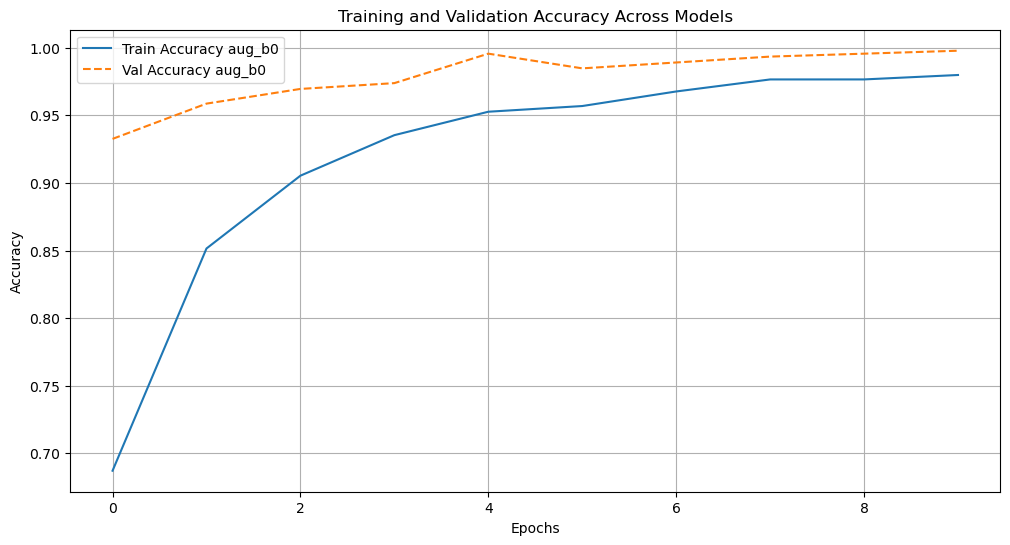

History for std_b0 is not available yet.
History for std_b2 is not available yet.
History for aug_b2 is not available yet.
History for std_m is not available yet.
History for aug_m is not available yet.


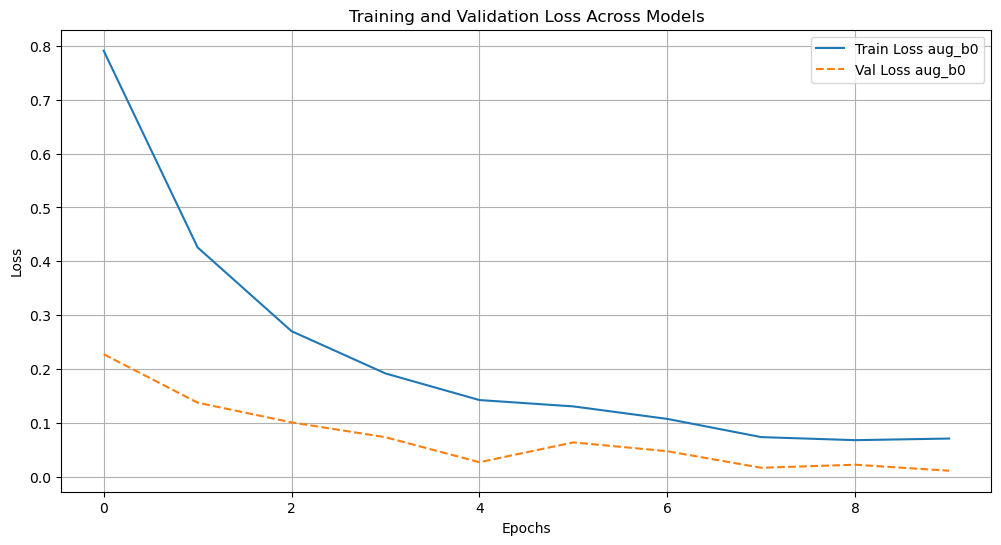

In [53]:
def plot_history(histories, title, metric):
    plt.figure(figsize=(12, 6))

    # Loop through all the histories
    for name, history in histories.items():
        if history is not None:  # Check if history is available
            plt.plot(history.history[metric], label=f'Train {metric.capitalize()} {name}')
            plt.plot(history.history[f'val_{metric}'], label=f'Val {metric.capitalize()} {name}', linestyle="--")
        else:
            print(f"History for {name} is not available yet.")

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Combine all the histories in a dictionary, where None represents a missing history
histories_accuracy = {
    'std_b0': history_std_b0 if 'history_std_b0' in globals() else None,
    'aug_b0': history_aug_b0 if 'history_aug_b0' in globals() else None,
    'std_b2': history_std_b3 if 'history_std_b3' in globals() else None,
    'aug_b2': history_aug_b2 if 'history_aug_b2' in globals() else None,
    'std_m': history_std_m if 'history_std_m' in globals() else None,
    'aug_m': history_aug_m if 'history_aug_m' in globals() else None
}

# Plot all accuracies in one figure (only available histories will be plotted)
plot_history(histories_accuracy, 'Training and Validation Accuracy Across Models', metric='accuracy')

# Similarly, plot the loss with the same method
plot_history(histories_accuracy, 'Training and Validation Loss Across Models', metric='loss')

In [56]:
# Dictionary to store evaluation results for each model
evaluation_results = {}

# Evaluate each model on the test dataset and store the results
# Assuming test_ds is your test dataset and each model is already trained
if 'history_std_b0' in globals():
    evaluation_results['std_b0'] = model_b0_std.evaluate(test_ds, verbose=1)

if 'history_aug_b0' in globals():
    evaluation_results['aug_v0'] = model_v0_aug.evaluate(test_ds, verbose=1)

if 'history_std_b2' in globals():
    evaluation_results['std_v2'] = model_v2_std.evaluate(test_ds, verbose=1)

if 'history_aug_b2' in globals():
    evaluation_results['aug_v2'] = model_v2_aug.evaluate(test_ds, verbose=1)

if 'history_std_m' in globals():
    evaluation_results['std_m'] = model_m_std.evaluate(test_ds, verbose=1)

if 'history_aug_m' in globals():
    evaluation_results['aug_m'] = model_m_aug.evaluate(test_ds, verbose=1)

# Print out the evaluation results for all models
for name, result in evaluation_results.items():
    print(f"\nEvaluation results for {name}:")
    print(f"Loss: {result[0]}")
    print(f"Accuracy: {result[1]}")
    print(f"F1 Score: {result[2]}")
    print(f"Precision: {result[3]}")
    print(f"Recall: {result[4]}")

NameError: name 'model_v0_aug' is not defined

# Result old

In [57]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history_aug_b0.history)
# Show 5 tails of dataframe
result_df.tail()

,accuracy,f1_score,loss,precision_1,recall_1,val_accuracy,val_f1_score,val_loss,val_precision_1,val_recall_1,learning_rate
5,0.956909,"(tf.Tensor(0.9473683, shape=(), dtype=float32)...",0.130559,0.962193,0.953630,0.984783,"(tf.Tensor(0.9795918, shape=(), dtype=float32)...",0.063700,0.984716,0.980435,0.0001
6,0.967682,"(tf.Tensor(0.9576547, shape=(), dtype=float32)...",0.107320,0.969826,0.963466,0.989130,"(tf.Tensor(0.9814126, shape=(), dtype=float32)...",0.047306,0.989107,0.986957,0.0001
7,0.976581,"(tf.Tensor(0.9654605, shape=(), dtype=float32)...",0.073506,0.979284,0.974239,0.993478,"(tf.Tensor(0.9961089, shape=(), dtype=float32)...",0.016559,0.993478,0.993478,0.0001
8,0.976592,"(tf.Tensor(0.9735788, shape=(), dtype=float32)...",0.067837,0.979275,0.973315,0.995643,"(tf.Tensor(0.9933774, shape=(), dtype=float32)...",0.022220,0.995643,0.995643,0.0001
9,0.979869,"(tf.Tensor(0.9725685, shape=(), dtype=float32)...",0.070850,0.981221,0.978464,0.997826,"(tf.Tensor(1.0, shape=(), dtype=float32), tf.T...",0.011084,0.997826,0.997826,0.0001


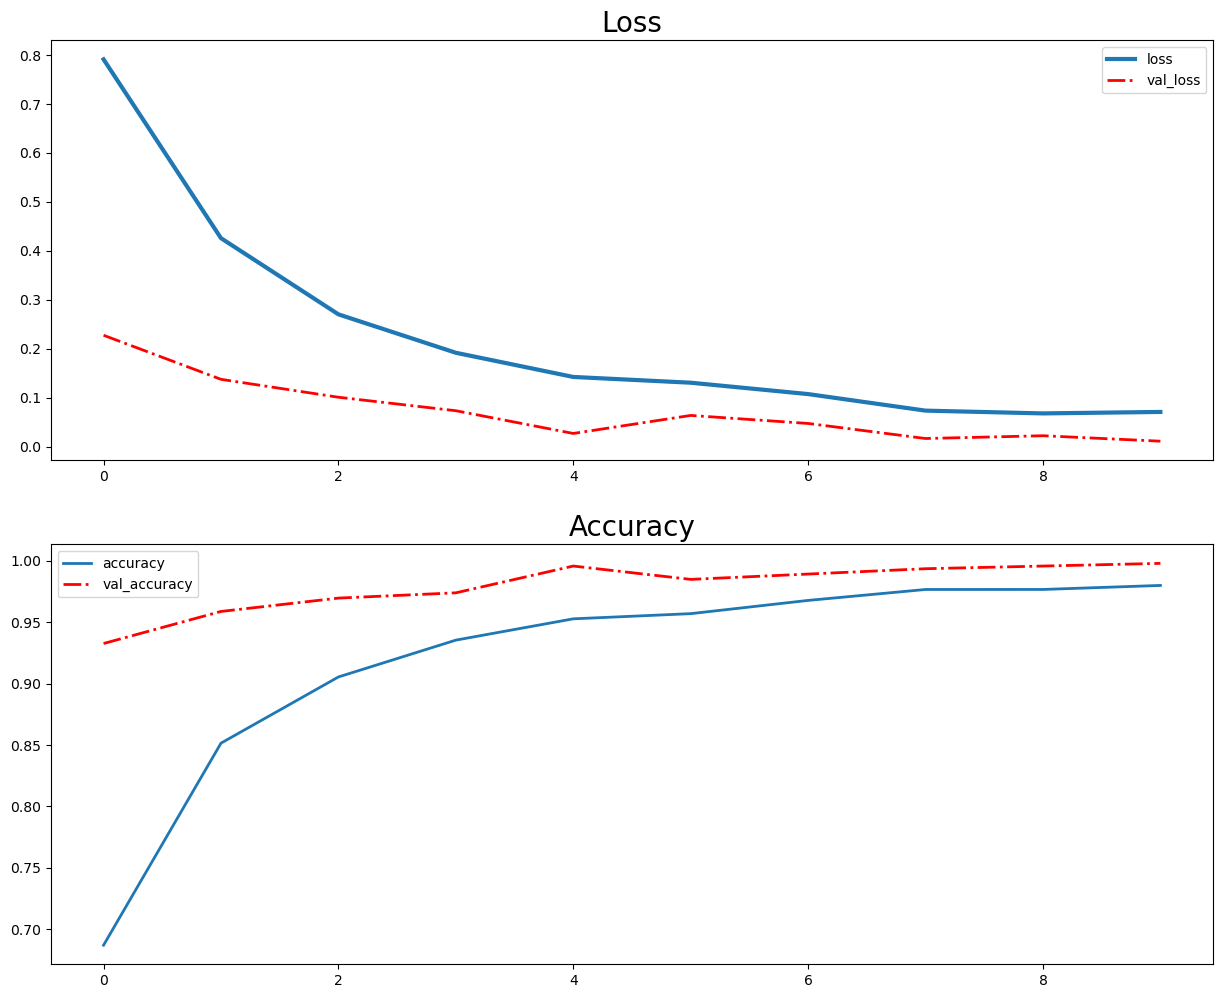

In [58]:
# Define a X variable to store range of epochs
x = np.arange(len(result_df))

# Create a plot with 3 row and 1 col with size of (15, 12)
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].set_xticks(np.arange(0, len(x), 2))
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].set_xticks(np.arange(0, len(x), 2))
ax[1].legend()

plt.show()

In [59]:
model.evaluate(test_ds, verbose=1)

115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9799 - f1_score: 0.9771 - loss: 0.0458 - precision_1: 0.9799 - recall_1: 0.9799


[0.028155671432614326,
 0.989130437374115,
 0.989130437374115,
 0.989130437374115,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.98181814, 1.        , 0.97942376, 1.        ], dtype=float32)>]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

2024-10-09 10:23:15.759389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


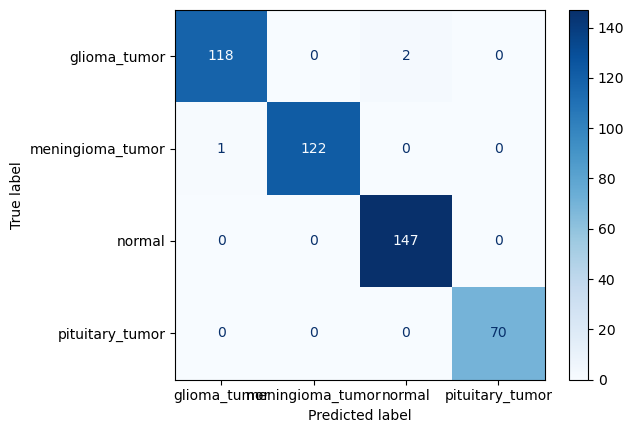

In [60]:
# Get the class names from the dataset
class_names = sorted(classes)

# Make predictions
y_pred = []
y_true = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

    # If labels are one-hot encoded, convert to class indices
    if len(labels.shape) > 1:
        labels = np.argmax(labels, axis=1)
    y_true.extend(labels)

# Convert to numpy arrays
# y_pred = np.array(y_pred)
# y_true = np.array(y_true)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [61]:
results = model.evaluate(test_ds)
test_loss = results[0]
test_accuracy = results[1]
test_f1_score = results[2]
test_precision = results[3]
test_recall = results[4]

print(f"Test accuracy: {test_accuracy}")

# Predict the test set
y_pred = []
y_true = []

# Iterate over the batches in the test dataset
for images, labels in test_ds:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

    if len(labels.shape) > 1:
        labels = np.argmax(labels, axis=1)
    y_true.extend(labels)

# Convert lists to numpy arrays
# y_pred = np.argmax(y_pred)
# y_true = np.argmax(y_true)

print('Classification Report')
print(classification_report(y_true, y_pred))

115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9930 - f1_score: 0.9890 - loss: 0.0238 - precision_1: 0.9930 - recall_1: 0.9930
Test accuracy: 0.9934782385826111
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms

2024-10-09 10:23:27.506687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [62]:
def classi_report(test_ds):
    if test_ds.__class__.__name__ == "_BatchDataset":
        test_ds = test_ds.unbatch()

    y_true = []
    y_pred = []
    pred_times = []

    for img, one_hot_label in test_ds:
        label = tf.argmax(one_hot_label).numpy()
        t1 = time.time()
        output = model.predict(img, verbose=0)
        t2 = time.time()
        pred = tf.squeeze(output)
        pred = tf.argmax(pred).numpy()
        y_true.append(label)
        y_pred.append(pred)
        pred_times.append(t2-t1)

    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    print(f"average prediction time: {np.mean(pred_times)} seconds")
    return classification_report(y_true, y_pred)

print(classi_report(test_ds))

average prediction time: 0.0602791806925898 seconds
              precision    recall  f1-score   support

           0       0.72      0.60      0.66        35
           1       0.61      0.77      0.68        26
           2       0.75      0.68      0.71        40
           3       0.35      0.43      0.39        14

    accuracy                           0.64       115
   macro avg       0.61      0.62      0.61       115
weighted avg       0.66      0.64      0.65       115



2024-10-09 10:23:34.697209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
